In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [4]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))


In [7]:
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [8]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [11]:
torch.cuda.is_available()

True

# Model

In [12]:
def model_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [13]:
model = model_detection(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Train Model

In [15]:

num_epochs = 10
model.to(device)
    
parameter = [p for p in model.parameters() if p.requires_grad]
opt = torch.optim.SGD(parameter, lr=0.005, momentum=0.9)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{q: w.to(device) for q, w in n.items()} for n in annotations]
        loss_dt = model([imgs[0]], [annotations[0]])
        loss = sum(los for los in loss_dt.values())        

        opt.zero_grad()
        loss.backward()
        opt.step() 
        print(f'Iteration: {i}/{(len(data_loader))}, Loss: {loss}')
        epoch_loss += loss
    print(f'epoch: {epoch} losse: {epoch_loss/i}')


Iteration: 1/214, Loss: 1.6260298490524292
Iteration: 2/214, Loss: 0.7188363075256348
Iteration: 3/214, Loss: 0.35622209310531616
Iteration: 4/214, Loss: 0.8805049061775208
Iteration: 5/214, Loss: 0.475751668214798
Iteration: 6/214, Loss: 0.4927263855934143
Iteration: 7/214, Loss: 0.2841845452785492
Iteration: 8/214, Loss: 0.4761572480201721
Iteration: 9/214, Loss: 0.6864391565322876
Iteration: 10/214, Loss: 1.5094690322875977
Iteration: 11/214, Loss: 0.62679123878479
Iteration: 12/214, Loss: 0.8254769444465637
Iteration: 13/214, Loss: 0.12608203291893005
Iteration: 14/214, Loss: 2.084843397140503
Iteration: 15/214, Loss: 0.38883176445961
Iteration: 16/214, Loss: 0.36175814270973206
Iteration: 17/214, Loss: 2.326270580291748
Iteration: 18/214, Loss: 0.32167866826057434
Iteration: 19/214, Loss: 0.11787568777799606
Iteration: 20/214, Loss: 0.8054229021072388
Iteration: 21/214, Loss: 0.20328505337238312
Iteration: 22/214, Loss: 0.5715758204460144
Iteration: 23/214, Loss: 0.247038245201110

In [16]:
i=0
for imgs, annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        if i == 4:
          break

In [17]:
model.eval()
predict = model(imgs)
predict

[{'boxes': tensor([[354.3841,  53.2794, 365.1981,  67.3411],
          [232.1520,  59.1948, 248.9168,  78.6910],
          [334.8934,  68.4884, 353.3218,  87.5655],
          [273.0151,  56.2025, 290.2753,  75.2191],
          [119.9040,  67.8804, 136.7541,  88.1229],
          [ 73.3540,  70.7610,  90.0412,  89.2222],
          [164.7633,  74.4590, 184.6847,  96.2958],
          [152.6989,  60.5999, 171.4254,  80.3534],
          [119.9513,  54.1522, 132.8762,  67.7895],
          [ 35.9338,  69.2176,  45.8919,  82.4822],
          [ 95.2134,  58.6231, 103.0075,  69.2200],
          [ 38.1932,  82.4521,  44.8859,  97.0071],
          [257.5956,  65.2441, 267.7775,  77.4838],
          [364.8996,  61.5284, 372.7233,  70.9040],
          [ 37.3514,  82.4658,  44.9611,  96.9782],
          [256.8554,  65.2763, 267.9789,  77.3048]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0'),
  'scores': tensor(

# Function to plot image

In [18]:
def plot_image(img_tensor, annotation, tru_annotation, area_boxes):
    
    fig,ax = plt.subplots(1, figsize=(8, 8))
    img = img_tensor.cpu().data
    ax.imshow(img.permute(1, 2, 0))

    area_boxes = area_boxes(annotation['boxes'], tru_annotation['boxes'])
    k = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box
        if area_boxes[k] != 0:
          if int(annotation["labels"][k]) == 1:
            clas = 'mask'
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
          elif int(annotation["labels"][k]) == 2:
            clas = 'incorrect mask'
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
          else:
            clas = 'no mask'
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
          try:
            clas = clas + ':' + str(round(float(annotation["scores"][k]),2))
          except:
            clas = clas

          plt.text(xmax, ymax, f'{clas}', size=(xmax-xmin)/4, rotation=0.,
          ha="right", va="top",
          bbox=dict(boxstyle="square",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
          )
          ax.add_patch(rect)
        k += 1

    plt.show()

In [19]:
def area_boxes(boxA, boxB):
  iou_list = []
  for boxa in boxA:
    max_iou = 0
    for boxb in boxB:
      xA = max(int(boxa[0]), int(boxb[0]))
      yA = max(int(boxa[1]), int(boxb[1]))
      xB = min(int(boxa[2]), int(boxb[2]))
      yB = min(int(boxa[3]), int(boxb[3]))

      interArea = abs(max(0, xB - xA) * max(0, yB - yA))
      if interArea == 0:
        iou = 0                            
                                                                                                 
      boxAArea = abs((int(boxa[2]) - int(boxa[0])) * (int(boxa[3]) - int(boxa[1])))
      boxBArea = abs((int(boxb[2]) - int(boxb[0])) * (int(boxb[3]) - int(boxb[1])))        
                                                                                          
      iou = (interArea) / (float(boxAArea + boxBArea - interArea))
      if float(iou) > max_iou:
        max_iou = float(iou)
    iou_list.append(round(max_iou, 2))                                                                         
  return iou_list

In [21]:
area_boxes(predict[0]['boxes'], annotations[0]['boxes'])

[0.87,
 0.85,
 0.85,
 0.89,
 0.82,
 0.85,
 0.83,
 0.86,
 0.8,
 0.76,
 0.71,
 0.8,
 0,
 0.03,
 0.67,
 0]

Prediction


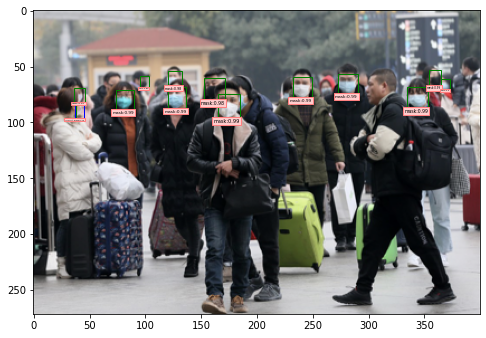

Target


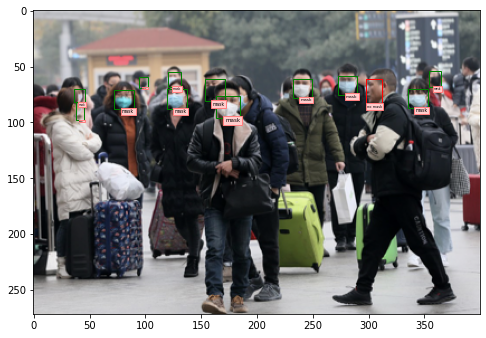

In [23]:
print("Prediction")
plot_image(imgs[0], predict[0], annotations[0], area_boxes)
print("Target")
plot_image(imgs[0], annotations[0], annotations[0], area_boxes)